<a href="https://colab.research.google.com/github/kevincovey/AATau/blob/master/Kevin/notebooks/Pleiades_Subsample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*This notebook was originally based on the Gala tutorial at this location: http://gala.adrian.pw/en/latest/dynamics/mockstreams.html*

It has since been heavily modified, to explore the properties of any tidal tails that the Segue 3 stellar cluster might be generating.  Along the way, we've optimized the notebook for the Google Colab environment, including adding a nice 'open in colab' button:





[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mwbest/WWU_2022/blob/kevin_covey_patch_3/Shared/Models/Segue3_GalaTutorialTest.ipynb)


## **(1) Imports**

In [4]:
!apt-get install gsl-bin libgsl0-dev

import sys
import math
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec

from mpl_toolkits import mplot3d # for 3d plots
import plotly.express as px 

import astropy.units as u
from astropy.table import Table
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord

!pip install gala
import gala.coordinates as gc
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic

!pip install git+https://github.com/mfouesneau/ezmist
from ezmist import get_one_isochrone

!pip install git+https://github.com/keflavich/imf
import imf
from imf import make_cluster

!pip install corner
import corner

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install astroquery
from astroquery.gaia import Gaia
from astroquery.vizier import Vizier


Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libgsl-dev' instead of 'libgsl0-dev'
gsl-bin is already the newest version (2.4+dfsg-6).
libgsl-dev is already the newest version (2.4+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/mfouesneau/ezmist to /tmp/pip-req-build-c4k2d6d3
  Running command git clone -q https://github.com/mfouesneau/ezmist /tmp/pip-req-build-c4k2d6d3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/keflavich/imf to /tmp/pip-req-build-c1kqdx23

## **(2) Pleiades information**

*Most of the data below was taken from [Lodieu et al. 2019](https://ui.adsabs.harvard.edu/abs/2019A%26A...628A..66L/abstract), [Meingast et al., 2021](https://ui.adsabs.harvard.edu/abs/2021A%26A...645A..84M/abstract), and [Danilov & Seleznev 2020](https://ui.adsabs.harvard.edu/abs/2020AstBu..75..407D/abstract).*

In [5]:
#measured properties
Pleiades_ra = 57.00*u.degree
Pleiades_dec = 24.0*u.degree
Pleiades_dist = (0.134)*u.kpc
Pleiades_pm_ra_cosdec = 19.5*u.mas/u.yr #from Lodieu et al. 2019
Pleiades_pm_dec = -45.5*u.mas/u.yr
Pleiades_radial_velocity = 5.3*u.km/u.s

#physical properties
Pleiades_mass = 478 * u.Msun
Pleiades_age = 120e6
Pleiades_feh = 0.0
Pleiades_core_radius = 1.0*u.pc
Pleiades_halo_radius = 4.5*u.pc

## distance modulus assumes a dist in kpc.
Pleiades_distMod = 5*math.log10( (Pleiades_dist.value*1e3)/10. ) 
print(Pleiades_distMod)
Pleiades_angular_radius = (360./(2*3.1415))*Pleiades_core_radius.value/(Pleiades_dist.value*1e3)
print(Pleiades_angular_radius)

5.635523991824039
0.42759305493858096


In [6]:
#initialize the coordinate frame
_ = coord.galactocentric_frame_defaults.set('v4.0')

#initialize the coordinate object that describes Segue3 in the current dat
Pleiades = coord.SkyCoord(ra=Pleiades_ra, dec= Pleiades_dec,
                        distance=Pleiades_dist,
                        pm_ra_cosdec= Pleiades_pm_ra_cosdec,
                        pm_dec= Pleiades_pm_dec,
                        radial_velocity=Pleiades_radial_velocity)
Pleiades_rep = Pleiades.transform_to(coord.Galactocentric).data
Pleiades_w0 = gd.PhaseSpacePosition(Pleiades_rep)

# Choosing either Plummer or Stone potential
#Segue3_pot = gp.PlummerPotential(m=Segue3_mass, b=4*u.pc, units=galactic)
Pleiades_pot = gp.StonePotential(m=Pleiades_mass, r_c=Pleiades_core_radius, r_h=Pleiades_halo_radius, units=galactic)

# Choosing the MW potential
mw = gp.MilkyWayPotential()
#mw = gp.BovyMWPotential2014()

df = ms.FardalStreamDF()
gen_Pleiades = ms.MockStreamGenerator(df, mw, progenitor_potential=Pleiades_pot)
Pleiades_stream, _ = gen_Pleiades.run(Pleiades_w0, Pleiades_mass,
                              dt=-0.1 * u.Myr, n_steps=1200)
Pleiades_stream_c = Pleiades_stream.to_coord_frame(coord.ICRS)

# **(3) Plots**


## right ascension vs declination

In [7]:
# Bestfit line and angles for plots
# Function that asks for the x&y axis values.

def bestfit(ra, dec):

  # Adding the center lines
  plt.axvline(x = np.mean(ra), color = 'k', label = 'axvline - full height')
  plt.axhline(y = np.mean(dec), color = 'k', label = 'axhline - full height') 

  # Bestfit line
  m, b = np.polyfit(ra,dec, 1)
  plt.plot(ra, m*ra+b, color = 'gold')

  # Calculating the angle of the slope using y=mx+b and theta=arctan(opp/adj)
  #plt.axvline(x = np.mean(ra)+1, color = 'silver', label = 'axvline - full height') # gray line
  opp = (m*(np.mean(ra)+1)+b) - np.mean(dec) # the lenght of the adjacent side of the triangle
  adj = (np.mean(ra)+1) - np.mean(ra) # the length of the opposite side of the triangle

  angle = np.arctan(opp/adj)
  print()
  print("Angle of slope: ", 90-(angle*180/np.pi), "degrees from North")
  print()

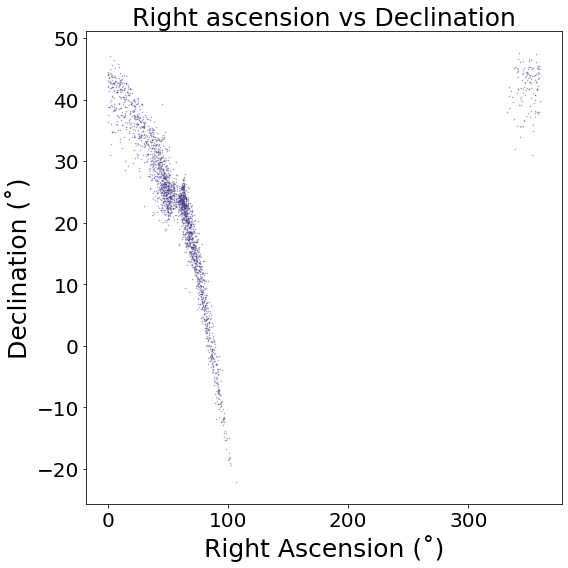

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(8,8), sharex=True)

axes.scatter(Pleiades_stream_c.ra.degree,
             Pleiades_stream_c.dec.degree, color = 'darkslateblue', marker='.', s=1, alpha=0.5)

#plt.axis('square')
plt.title("Right ascension vs Declination", fontsize = 25)

axes.set_xlabel(r'Right Ascension (˚)', fontsize = 25)
axes.set_ylabel(r'Declination (˚)', fontsize = 25)
axes.tick_params(axis='both', which='major', labelsize=20)

#plt.xlim(326.5, 314)
#plt.ylim(13.5, 26)

fig.tight_layout()

#bestfit(Segue3_stream_c.ra.degree, Segue3_stream_c.dec.degree)

## Radial Velocity vs Right Ascension

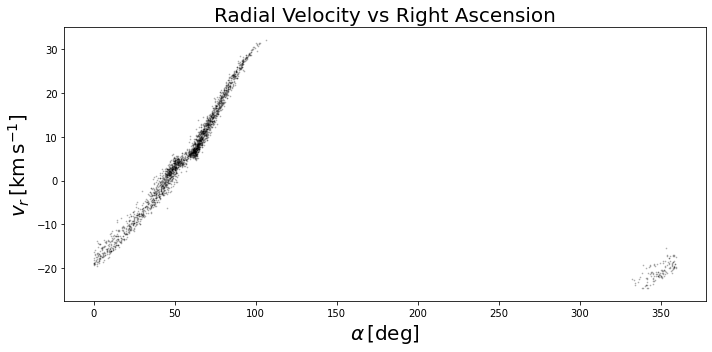

In [10]:
fig, axes = plt.subplots(1, 1, figsize=(10,5), sharex=True)

axes.scatter(Pleiades_stream_c.ra.degree,
                   Pleiades_stream_c.radial_velocity.to(u.km/u.s), marker='.', s=2, alpha=0.25, color='k')

plt.title("Radial Velocity vs Right Ascension", fontsize = 20)

#plt.xlim(326.5, 314)
#plt.ylim(-220, -120)

axes.set_xlabel(r'$\alpha\,[{\rm deg}]$', fontsize = 20)
axes.set_ylabel(r'$v_r\,[{\rm km}\,{\rm s}^{-1}]$', fontsize = 20)

fig.tight_layout()

## Y vs X; Z vs X; Z vs Y







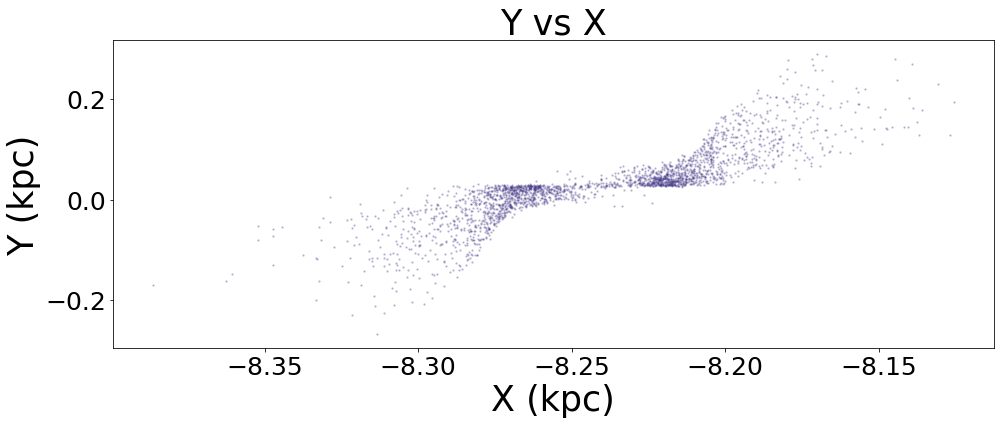

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(14,6))

axes.scatter(Pleiades_stream.x,
                   Pleiades_stream.y, marker='o', s=2, alpha=0.25, color='darkslateblue')

plt.title("Y vs X", fontsize = 35)

axes.set_xlabel(r'X (kpc)', fontsize = 35)
axes.set_ylabel(r'Y (kpc)', fontsize = 35)

#plt.xlim(4, -1)
#plt.ylim(25, )

axes.tick_params(axis='both', which='major', labelsize=25)

fig.tight_layout()


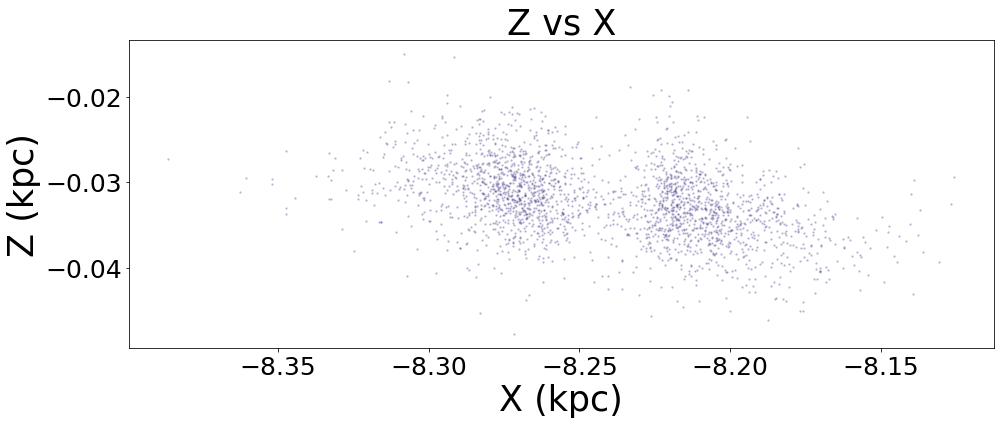

In [12]:
fig, axes = plt.subplots(1, 1, figsize=(14,6))

axes.scatter(Pleiades_stream.x,
                   Pleiades_stream.z, marker='o', s=2, alpha=0.25, color='darkslateblue')

plt.title("Z vs X", fontsize = 35)

axes.set_xlabel(r'X (kpc)', fontsize = 35)
axes.set_ylabel(r'Z (kpc)', fontsize = 35)
axes.tick_params(axis='both', which='major', labelsize=25)

fig.tight_layout()

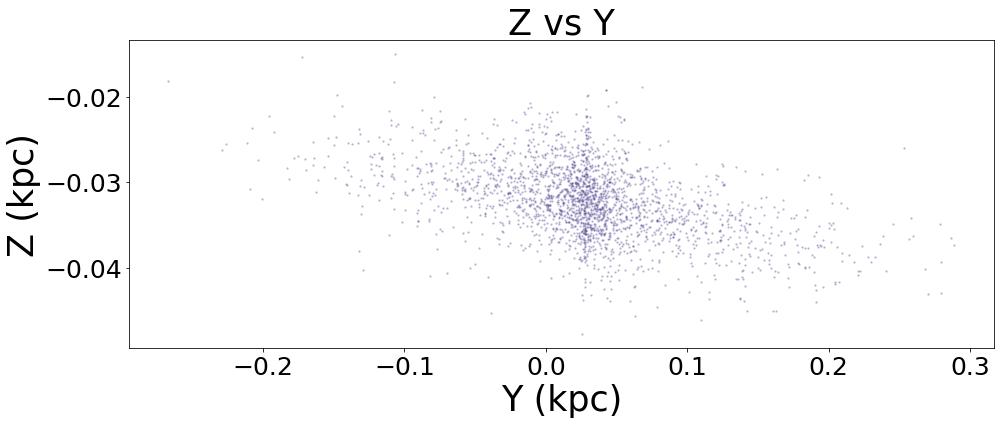

In [13]:
fig, axes = plt.subplots(1, 1, figsize=(14,6))

axes.scatter(Pleiades_stream.y,
                   Pleiades_stream.z, marker='o', s=2, alpha=0.25, color='darkslateblue')

plt.title("Z vs Y", fontsize = 35)

axes.set_xlabel(r'Y (kpc)', fontsize = 35)
axes.set_ylabel(r'Z (kpc)', fontsize = 35)
axes.tick_params(axis='both', which='major', labelsize=25)


fig.tight_layout()

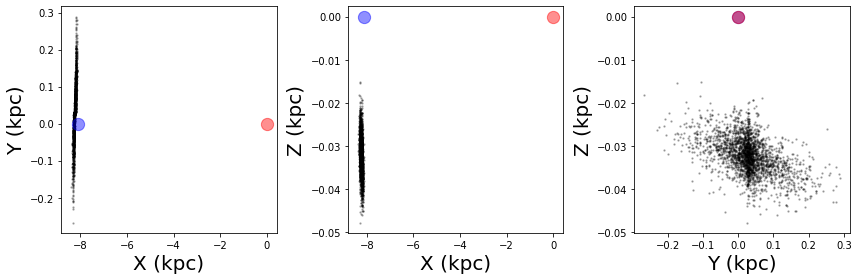

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))

axes[0].scatter(Pleiades_stream.x,
                Pleiades_stream.y, marker='o', s=2, alpha=0.25, color='k')

axes[0].scatter([-8.1,-8.1], [0,0], marker='o', s=150, alpha=0.25, color='blue')
axes[0].scatter([0,0], [0,0], marker='o', s=150, alpha=0.25, color='red')

axes[1].scatter(Pleiades_stream.x,
                Pleiades_stream.z, marker='o', s=2, alpha=0.25, color='k')

axes[1].scatter([-8.1,-8.1], [0,0], marker='o', s=150, alpha=0.25, color='blue')
axes[1].scatter([0,0], [0,0], marker='o', s=150, alpha=0.25, color='red')

axes[2].scatter(Pleiades_stream.y,
                Pleiades_stream.z, marker='o', s=2, alpha=0.25, color='k')

axes[2].scatter([0,0], [0,0], marker='o', s=150, alpha=0.25, color='blue')
axes[2].scatter([0,0], [0,0], marker='o', s=150, alpha=0.25, color='red')

axes[0].set_xlabel(r'X (kpc)', fontsize = 20)
axes[1].set_xlabel(r'X (kpc)', fontsize = 20)
axes[2].set_xlabel(r'Y (kpc)', fontsize = 20)
axes[0].set_ylabel(r'Y (kpc)', fontsize = 20)
axes[1].set_ylabel(r'Z (kpc)', fontsize = 20)
axes[2].set_ylabel(r'Z (kpc)', fontsize = 20)

fig.tight_layout()

## Kevin's test of showing XYZ corner plots, with UVW velocities added.


Extract UVW velocities for Segue 3 from the object initialized above

In [15]:
#save the velocity components to new variables for convenience
Pleiades_V_x = Pleiades.transform_to(coord.Galactocentric()).v_x
Pleiades_V_y = Pleiades.transform_to(coord.Galactocentric()).v_y
Pleiades_V_z = Pleiades.transform_to(coord.Galactocentric()).v_z

#print them out to confirm they are... reasonable.
print(Pleiades_V_x.value, Pleiades_V_y.value, Pleiades_V_z.value)

6.61968512954994 217.62764997302864 -6.183967941503795


Indeed - the stream seems to be stretching mostly in X, then Z, and not so much in Y, and that matches how the velocities are too.  Great!

First, make a set of subplots that show the XYZ plots with shared axes, and with the axes trimmed to only show the tails themselves.

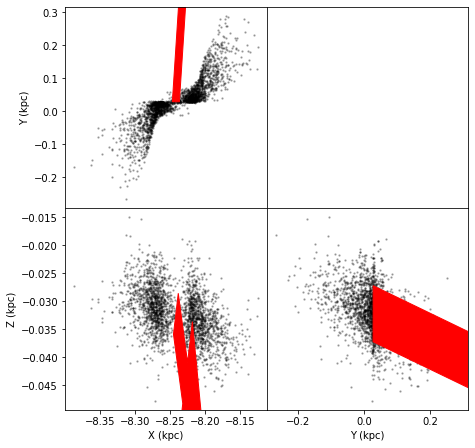

In [16]:
#set up a grid of figures (and we'll leave the top empty
fig, axs = plt.subplots(2, 2, figsize=(7, 7))

#set up the upper left figure as an XY plot, with no x tick marks or names
axs[0, 0].scatter(Pleiades_stream.x, Pleiades_stream.y, marker='o', s=2, alpha=0.25, color='k')
axs[0, 0].set_ylabel("Y (kpc)")
axs[0, 0].tick_params(bottom = False, labelbottom = False)
#add an arrow to the panel to show the cluster's UVW velocities; scale the velocities by 100 to make the arrow's lengths make sense in the panel (where lengths are measured in kpc, not km/s!)
arr_width = .01   #  I don't know what unit it is here.
axs[0, 0].arrow(np.nanmedian(Pleiades_stream.x.value), np.nanmedian(Pleiades_stream.y.value), Pleiades_V_x.value/500., Pleiades_V_y.value/500., width = arr_width, head_width = 3 * arr_width, head_length = 9 * arr_width, color = 'red')

#set up the bottom left figure as an XZ plot, with tick marks & names on both axes
axs[1, 0].scatter(Pleiades_stream.x, Pleiades_stream.z, marker='o', s=2, alpha=0.25, color='k')
axs[1, 0].set_ylabel("Z (kpc)")
axs[1, 0].set_xlabel("X (kpc)")
axs[1, 0].arrow(np.nanmedian(Pleiades_stream.x.value), np.nanmedian(Pleiades_stream.z.value), Pleiades_V_x.value/500., Pleiades_V_z.value/500., width = arr_width, head_width = 3 * arr_width, head_length = 9 * arr_width, color = 'red')

#set up the bottom right figure as an YZ plot, with tick marks & names on the X axis
axs[1, 1].scatter(Pleiades_stream.y, Pleiades_stream.z, marker='o', s=2, alpha=0.25, color='k')
axs[1, 1].set_xlabel("Y (kpc)")
axs[1, 1].tick_params(left = False, labelleft = False)
axs[1, 1].arrow(np.nanmedian(Pleiades_stream.y.value), np.nanmedian(Pleiades_stream.z.value), Pleiades_V_y.value/500., Pleiades_V_z.value/500., width = arr_width, head_width = 3 * arr_width, head_length = 9 * arr_width, color = 'red')

#set up the upper right plot as a blank square
axs[0, 1].tick_params(bottom = False, labelbottom = False, left = False, labelleft = False)

#now adjust the wspace and hspace settings so the axes get shared.
fig.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.0, 
                    hspace=0.0)

now add the dots for the Sun and Galactic center: let the plots rescale, and add a legend in the upper panel that was empty before

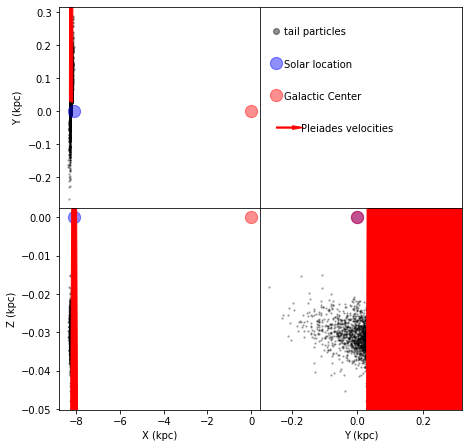

In [17]:
#now make a similar corner plot, but indicate the location of the sun and Galactic center.
arr_width = .15   #  I don't know what unit it is here.

#set up a grid of figures (and we'll leave the top empty
fig, axs = plt.subplots(2, 2, figsize=(7, 7))

#set up the upper left figure as an XY plot, with no x tick marks or names
axs[0, 0].scatter(Pleiades_stream.x, Pleiades_stream.y, marker='o', s=2, alpha=0.25, color='k')
axs[0, 0].set_ylabel("Y (kpc)")
axs[0, 0].tick_params(bottom = False, labelbottom = False)

#add in the sun, galactic center, and velocity arrow
axs[0,0].scatter([-8.1,-8.1], [0,0], marker='o', s=150, alpha=0.25, color='blue')
axs[0,0].scatter([0,0], [0,0], marker='o', s=150, alpha=0.25, color='red')
axs[0, 0].arrow(np.nanmedian(Pleiades_stream.x.value), np.nanmedian(Pleiades_stream.y.value), Pleiades_V_x.value/500., Pleiades_V_y.value/500., width = arr_width, head_width = 3 * arr_width, head_length = 9 * arr_width, color = 'red')

#set up the bottom left figure as an XZ plot, with tick marks & names on both axes
axs[1, 0].scatter(Pleiades_stream.x, Pleiades_stream.z, marker='o', s=2, alpha=0.25, color='k')
axs[1, 0].set_ylabel("Z (kpc)")
axs[1, 0].set_xlabel("X (kpc)")

#add in the sun, galactic center, and velocity arrow
axs[1, 0].arrow(np.nanmedian(Pleiades_stream.x.value), np.nanmedian(Pleiades_stream.z.value), Pleiades_V_x.value/500., Pleiades_V_z.value/500., width = arr_width, head_width = 3 * arr_width, head_length = 9 * arr_width, color = 'red')
axs[1,0].scatter([-8.1,-8.1], [0,0], marker='o', s=150, alpha=0.25, color='blue')
axs[1,0].scatter([0,0], [0,0], marker='o', s=150, alpha=0.25, color='red')

#set up the bottom right figure as an YZ plot, with tick marks & names on the X axis
axs[1, 1].scatter(Pleiades_stream.y, Pleiades_stream.z, marker='o', s=2, alpha=0.25, color='k')
axs[1, 1].set_xlabel("Y (kpc)")
axs[1, 1].tick_params(left = False, labelleft = False)

#add in the sun, galactic center, and velocity arrow
axs[1, 1].arrow(np.nanmedian(Pleiades_stream.y.value), np.nanmedian(Pleiades_stream.z.value), Pleiades_V_y.value/500., Pleiades_V_z.value/500., width = arr_width, head_width = 3 * arr_width, head_length = 9 * arr_width, color = 'red')
axs[1, 1].scatter([0,0], [0,0], marker='o', s=150, alpha=0.25, color='blue')
axs[1, 1].scatter([0,0], [0,0], marker='o', s=150, alpha=0.25, color='red')


#set up the upper right plot as a legend


#set the range of the plot so we can place objects within it
axs[0, 1].set_xlim( [0,25])
axs[0, 1].set_ylim( [0,25])

#add dots for each symbol type
axs[0, 1].scatter( [2, 2], [22,22], marker='o', s=35, alpha=0.25, color='k')
axs[0, 1].scatter( [2, 2], [18,18], marker='o', s=150, alpha=0.25, color='blue')
axs[0, 1].scatter( [2, 2], [14,14], marker='o', s=150, alpha=0.25, color='red')
axs[0, 1].arrow( 2, 10, 2, 0, width = arr_width, head_width = 3 * arr_width, head_length = 9 * arr_width, color = 'red')

#add labels to identify each point
axs[0, 1].text(3, 21.5, 'tail particles', fontsize = 10)
axs[0, 1].text(3, 17.5, 'Solar location', fontsize = 10)
axs[0, 1].text(3, 13.5, 'Galactic Center', fontsize = 10)
axs[0, 1].text(5, 9.5, 'Pleiades velocities', fontsize = 10)

axs[0, 1].tick_params(bottom = False, labelbottom = False, left = False, labelleft = False)

#now adjust the wspace and hspace settings so the axes get shared.
fig.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.0, 
                    hspace=0.0)

## Proper Motion in Right Ascension vs Proper Motion in Declination



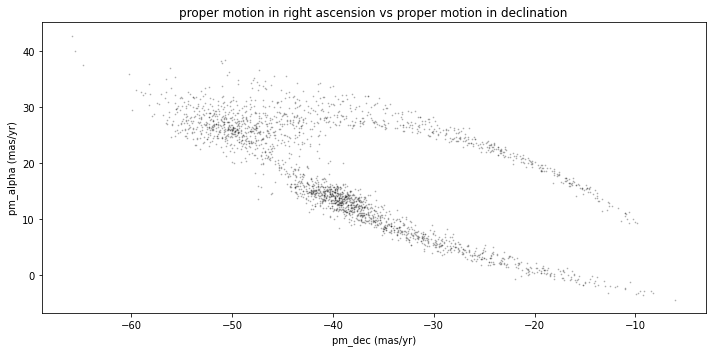

In [18]:
fig, axes = plt.subplots(1, 1, figsize=(10,5), sharex=True)

plt.title("proper motion in right ascension vs proper motion in declination")

axes.scatter(Pleiades_stream_c.pm_dec,
                   Pleiades_stream_c.pm_ra_cosdec, marker='.', s=2, alpha=0.25, color='k') 

#plt.xlim(-1.65, -1.90)
#plt.ylim(-2.76, -2.63)

axes.set_ylabel(r'pm_alpha (mas/yr)')
axes.set_xlabel(r'pm_dec (mas/yr)')

fig.tight_layout()

## Proper Motion in Right Ascension vs Right Ascension

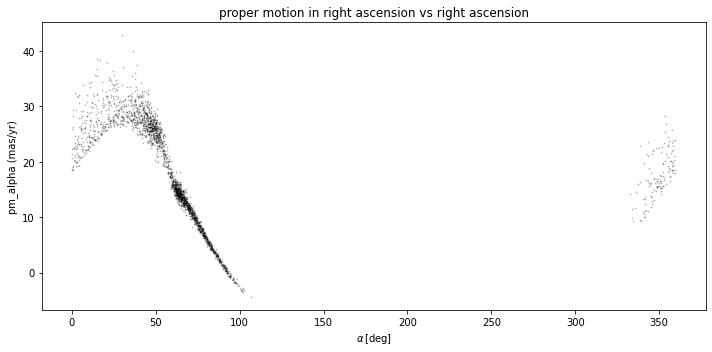

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(10,5), sharex=True)

plt.title("proper motion in right ascension vs right ascension")

axes.scatter(Pleiades_stream_c.ra.degree,
                   Pleiades_stream_c.pm_ra_cosdec, marker='.', s=2, alpha=0.25, color='k')

#plt.xlim(325, 315)
#plt.ylim(-2.76, -2.63)

axes.set_ylabel(r'pm_alpha (mas/yr)')
axes.set_xlabel(r'$\alpha\,[{\rm deg}]$')

fig.tight_layout()

## Proper Motion in Declination vs Right Ascension

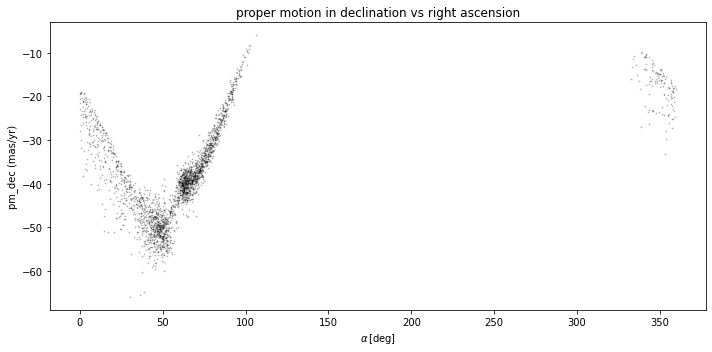

In [20]:
fig, axes = plt.subplots(1, 1, figsize=(10,5), sharex=True)

plt.title("proper motion in declination vs right ascension")

axes.scatter(Pleiades_stream_c.ra.degree,
                   Pleiades_stream_c.pm_dec, marker='.', s=2, alpha=0.25, color='k')

#plt.xlim(325, 315)
#plt.ylim(-1.90, -1.55)

axes.set_ylabel(r'pm_dec (mas/yr)')
axes.set_xlabel(r'$\alpha\,[{\rm deg}]$')

fig.tight_layout()      

# **(4) Interactive 3D plot of XYZ**

In [21]:
fig = px.scatter_3d(x=Pleiades_stream.x, y = Pleiades_stream.y, z=Pleiades_stream.z, width=1000, height=1000)
fig.update_traces(marker=dict(size=2, color='DarkSlateGrey'), selector=dict(mode='markers'))

# fig = px.scatter_3d(x=Segue3_alt_stream.x, y = Segue3_alt_stream.y, z=Segue3_alt_stream.z, width=1000, height=1000)
# fig.update_traces(marker=dict(size=2, color='blue'), selector=dict(mode='markers'))

# **Sections 5 and 6 show how we obtained the proper motions and radial velocity.**

## **(5) Extracting proper motions with Gaia**

In [ ]:
# Hughes table

Hughes_table = Vizier(catalog="J/AJ/154/57/objects",
             columns=['*', '_RAJ2000', '_DEJ2000'], row_limit = 1000).query_constraints(Vmag="15.0..25.0")[0]

print(Hughes_table.colnames)

['_RAJ2000', '_DEJ2000', 'Object', 'O13', 'F11', 'Z', 'RAJ2000', 'DEJ2000', 'Xpix', 'Ypix', 'HRV', 'Imag', 'Vmag', 'T1mag', 'Cmag', 'umag', 'gmag', 'rmag', 'imag', 'zmag']


In [ ]:
# Gaia table

coords = SkyCoord(ra=320.37917, dec=19.11722, unit=(u.degree, u.degree),frame='icrs' )
width = u.Quantity(.1, u.deg)
height = u.Quantity(.1, u.deg)
Gaia.ROW_LIMIT = -1
Gaia_raw = Gaia.query_object_async(coordinate = coords, width = width, height=height)
#print(Gaia_raw.colnames)

gaia_table = Table()
gaia_table['RA'] = Gaia_raw['ra']
gaia_table['Dec'] = Gaia_raw['dec']
gaia_table['RA PM'] = Gaia_raw['pmra']
gaia_table['DEC PM'] = Gaia_raw['pmdec']

#print(gaia_table)

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


In [ ]:
# Cross-matching

print(np.nonzero( ((Hughes_table['HRV'] > -176) & (Hughes_table['HRV'] < -156)) )[0])
match_rows = [] #creating an empty list to use in the loop
#loop over the length of the Hughes table, getting a list of stars around that spot from Gaia
for i in np.nonzero( ((Hughes_table['HRV'] > -176) & (Hughes_table['HRV'] < -156)) )[0] :
  coord = SkyCoord(ra=Hughes_table['RAJ2000'][i], dec=Hughes_table['DEJ2000'][i], 
                  unit=(u.degree, u.degree),frame='icrs' )
  width = u.Quantity(0.005, u.deg) 
  height = u.Quantity(0.005, u.deg) 
  Gaia.ROW_LIMIT = -1
  Gaia_match = Gaia.query_object_async(coordinate=coord, width=width, height=height)
  #get the first star on each list of stars from gaia and add that to the list of matches
  if len(Gaia_match['source_id'] !=0): #some of the fields Gaia got around the stars had nothing in them, this if statement skips over those ones
    match = Gaia_match[0]
    match_rows.append(match)

#put the matches into a table and use the same column names as Gaia did
g_matches = Table(rows=match_rows, names=Gaia_match.colnames)
#g_matches

[  3  14  24  27  33  52  72  87  89 100 102 107 112 127 130 131 133 134
 135 154 155 156 173]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


In [ ]:
import math
# Getting the proper motions

#this grabs each proper motion from the list, gathers them up and takes the median of each for Erika's model
ra = []
dec = []
pmra_error = []
pmdec_error = []
pmras = []
pmdecs = []

counter = 0

for i in range(len(g_matches['source_id'])):
  if type(g_matches['pmra'][i]) == np.float64:
    
    pmras.append(g_matches['pmra'][i])
    pmdecs.append(g_matches['pmdec'][i])
    ra.append(g_matches['ra'][i])
    dec.append(g_matches['dec'][i])
    pmra_error.append(g_matches['pmra_error'][i])
    pmdec_error.append(g_matches['pmdec_error'][i])
    print("pmras: ", pmras[counter], "pmdecs: ", pmdecs[counter], "ra: ", ra[counter], "dec: ", dec[counter], "pmra_error: ", pmra_error[counter], "pmdec_error: ", pmdec_error[counter])
    counter = counter + 1
print()    

pmras = pmras[:-1]
pmdecs = pmdecs[:-1]

med_pmra = np.median(pmras)
med_pmdec = np.median(pmdecs)

pmra_error = pmra_error[:-1]

pmra_uncert = (np.mean(pmra_error))/np.sqrt(5)
print("PMRA uncertainty: ", pmra_uncert)
pmdec_uncert = (np.mean(pmdec_error))/np.sqrt(5)
print("PMDEC uncertainty: ", pmdec_uncert)
print()
print('Median pmra = {}'.format(med_pmra))
print('Median pmdec = {}'.format(med_pmdec))
print()


pmras:  -0.879838268904047 pmdecs:  -1.7820172394908258 ra:  320.3844813121914 dec:  19.097803073149556 pmra_error:  1.3372463442424165 pmdec_error:  1.0545319716487753
pmras:  -4.968388500874267 pmdecs:  -1.3532818067662684 ra:  320.37239402986444 dec:  19.120099402331437 pmra_error:  2.289239705401332 pmdec_error:  1.7783117660243875
pmras:  -2.7118085512474237 pmdecs:  -6.393054173224082 ra:  320.3681384375463 dec:  19.100135774064054 pmra_error:  1.4969050538034725 pmdec_error:  1.211504723096283
pmras:  -1.568524389060312 pmdecs:  -1.6343858567066731 ra:  320.3795428468104 dec:  19.131038976327346 pmra_error:  1.5055207576750638 pmdec_error:  1.2518666356967199
pmras:  -5.776325466310524 pmdecs:  -3.6266460848155555 ra:  320.3809570471935 dec:  19.116696506384383 pmra_error:  3.4062470752508203 pmdec_error:  2.42086141626346
pmras:  -4.968388500874267 pmdecs:  -1.3532818067662684 ra:  320.37239402986444 dec:  19.120099402331437 pmra_error:  2.289239705401332 pmdec_error:  1.778311

## **(6) Radial velocity filtering** *(with comments from Dr. Covey)*

FROM KEVIN: radial velocity is a convenient property to use for establishing objects as confident cluster members. After all, even if the cluster members were closely located, if they all had different radial velocities, they will split apart quickly and no longer look like a cluster for long.  So anything in a relatively old object that does look like a cluster will need to have fairly similar radial velocities to stick together for a while.

To determine what RV segue 3 cluster members should have, let's look at the distribution of RVs that the members do have, and see if there is a particular RV that appears to be strongly favored.  

Start by printing out all the RVs in the table....

In [ ]:
print(Hughes_table['HRV'])

 HRV  
km / s
------
    --
    --
    --
-163.3
    --
    --
 -22.0
    --
    --
 -49.0
   ...
    --
 -79.9
    --
    --
    --
    --
    --
-158.9
    --
    --
Length = 176 rows


Hmmm.  Note that only a small set of the members in the Hughes table actually have RVs listed -- it can be a tough measurement to make! 

But lets use the measurements we do have to see if there is a preferred value. 

start by making a histogram of all the RVs that do exist, and see if that shows a peak at a preferred velocity.  We'll start with a coarse binning, since I see values above ranging from -163 to -22 km/sec...


(array([ 0.,  1., 27.,  0.,  4.,  4.]),
 array([-300, -250, -200, -150, -100,  -50,    0]),
 <a list of 6 Patch objects>)

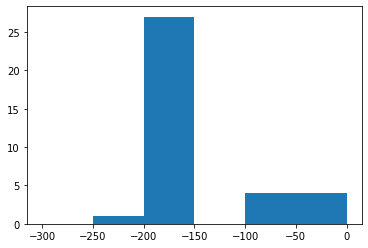

In [ ]:
plt.hist(Hughes_table['HRV'], bins=[-300,-250,-200,-150,-100,-50,-0])

Hmm.  looks like the vast majority of the RVs are between -200 and -150 km/sec.  Let's zoom in.

(array([ 0.,  2.,  4., 18.,  3.]),
 array([-200, -190, -180, -170, -160, -150]),
 <a list of 5 Patch objects>)

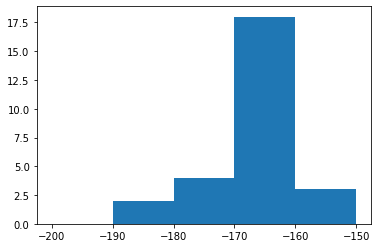

In [ ]:
plt.hist(Hughes_table['HRV'], bins=[-200,-190,-180,-170,-160,-150])

And it looks like most of those objects are between -170 and -160 km/sec.  Just to be safe, let's zoom in again to -180 and -150...

(array([ 1.,  3., 10.,  8.,  2.,  1.]),
 array([-180, -175, -170, -165, -160, -155, -150]),
 <a list of 6 Patch objects>)

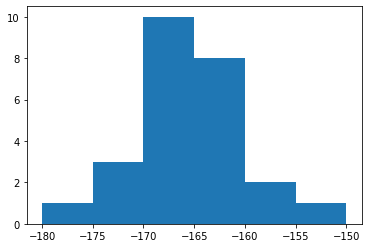

In [ ]:
plt.hist(Hughes_table['HRV'], bins=[-180,-175,-170,-165,-160,-155,-150])

That is starting to look more gaussian-ish, so let's go ahead and take the median of all the stars with RVs between -180 and -150, and call that the cluster's central velocity.
To do this, we can use the np.nonzero command to find the objects in the Hughes table that meet this criteria. Let's test that we can actually do this:

In [ ]:
in_RV_range = np.nonzero( ((Hughes_table['HRV'] > -180) & (Hughes_table['HRV'] < -150)) ) 
print(in_RV_range)
print()
print(len(in_RV_range[0]))

(array([  3,  14,  24,  27,  33,  52,  61,  72,  87,  89, 100, 102, 107,
       112, 127, 130, 131, 133, 134, 135, 142, 154, 155, 156, 173]),)

25


That does indeed look like a list of about 25 sources, which seems about right.  Notice also that the result of the np.nonzero command is a funky 2-D array, where one of the axes is zero, so when using the len() command to count the objects in it, I had to add a suffix of [0] to select just the axis I wanted.  Its weird, but I've gotten used to it...

Finally, let's calculate the median RV of this subset of objects.

In [ ]:
print('Median RV: ', np.median(Hughes_table['HRV'][in_RV_range]))
print("RV std dv: ", np.std((Hughes_table['HRV'][in_RV_range])/25)) 
print()

Median RV:  -166.10000610351562
RV std dv:  0.20920737533455883



/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:755: UserWarning:




# **Isochrone fitting**

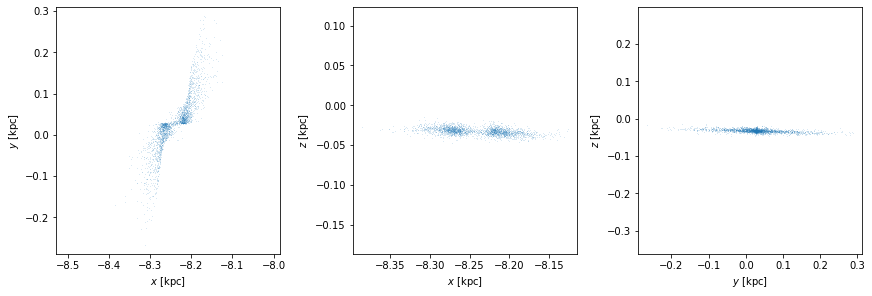

In [22]:
#Segue3_stream, _ = gen_Segue3.run(
#    Segue3_w0, 
#    dt=-1., t1=0, t2=-2.6*u.Gyr,
#    prog_mass=239*u.Msun,  ###NOTE -- I believe this is changing Segue 3's 
                            ###        mass; I think the better change to test 
                            ###        is the limit on the tails' cumulative
                            ###        mass, which occurs below (I'll flag 
                            ###        where it does.)
#    n_particles=4
#)

Pleiades_stream.shape

_ = Pleiades_stream.plot(marker='o', lw=0, s=1., alpha=0.2)

In [23]:
from scipy.interpolate import interp1d

#define an isochrone consistent with Segue 3's properties
iso = get_one_isochrone(age=Pleiades_age, FeH=Pleiades_feh, output_option='photometry', output='UBVRIplus')

#now identify the magnitudes that correspond to this isochrone
G_mag_interp = interp1d(iso['initial_mass'], iso['Gaia_G_EDR3'], bounds_error=False)
Rp_mag_interp = interp1d(iso['initial_mass'], iso['Gaia_RP_EDR3'], bounds_error=False)

Interrogating http://waps.cfa.harvard.edu/MIST/iso_form.php...
Request...done.
Reading content...done.
b'PK\x03\x04\x14\x00\x00\x00\x08\x00\xb0\xb2\tU\xba`\xe4\xa4\xb9\xf5\x03\x00\xe6\xdc\x11\x00\x1e\x00\x00\x00MIST_iso_62f31625efa30.iso.cmd\xbc\xfd[\xcf5Yv\x9d\x07\xde\xfbW$\xe0\x1b\x0b\xadL\xad\xf3\xa1\x01_H\x16m\xa9e\x02\x02)\xcbp7\x1a\x852\x91\x92\n' <class 'bytes'> b'PK\x03\x04\x14\x00\x00\x00\x08\x00'
decompressing archive (type=zip)...done.


In [24]:
#make a set of stars comparable to the cluster stars
cluster_masses = imf.make_cluster(Pleiades_mass, massfunc='kroupa')   

#check the total + ordering of cluster masses selected from the IMF.
#total makes sense, and ordering doesn't appear to be strictly increasing or
#anything, so let's not shuffle until it is clear we need to.
#print(cluster_masses[0:20])
#print(np.sum(cluster_masses))

#interpolate the masses onto the magnitude isochrone
cluster_G_mag = G_mag_interp(cluster_masses)
cluster_Rp_mag = Rp_mag_interp(cluster_masses)

#give the cluster stars actual ras and decs, consistent with the cluster's 
#core size
cluster_ras = Pleiades_ra.value*np.ones(len(cluster_masses)) + np.random.randn(len(cluster_masses))*Pleiades_angular_radius
cluster_decs = Pleiades_dec.value*np.ones(len(cluster_masses)) + np.random.randn(len(cluster_masses))*Pleiades_angular_radius

#calculate the distance modulus that corresponds to the cluster's distance
cluster_mg = cluster_G_mag + Pleiades_distMod
cluster_mrp = cluster_Rp_mag + Pleiades_distMod

#save a detection limit for the cluster + tail stars
detection_limit = 23

#select stars that are brighter than 23rd magnitude
detectable_cluster_stars = np.argwhere(cluster_mg < detection_limit)
print(len(detectable_cluster_stars))

Total cluster mass is 477.903 (limit was 478)
735


Text(0, 0.5, 'G')

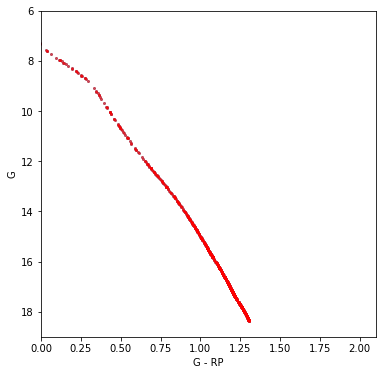

In [28]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(cluster_mg - cluster_mrp, cluster_mg, alpha=0.5, s=4)
ax.scatter(cluster_mg[detectable_cluster_stars] - cluster_mrp[detectable_cluster_stars], cluster_mg[detectable_cluster_stars], color = 'red', alpha=0.5, s=4)
ax.set_xlim(0, 2.1)
ax.set_ylim(19, 6)
ax.set_xlabel('G - RP')
ax.set_ylabel('G')

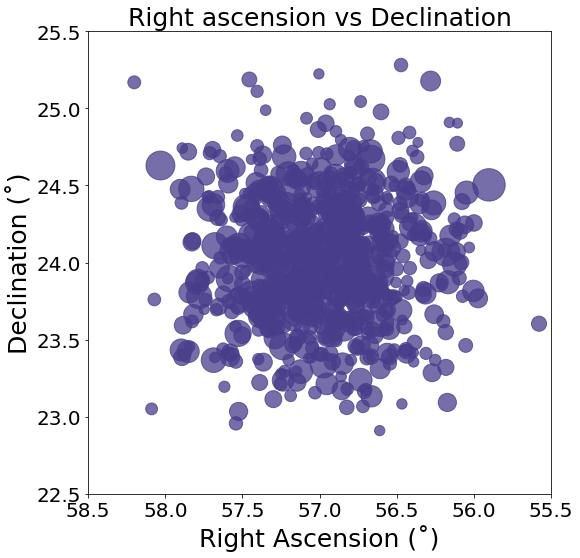

In [31]:
fig, axes = plt.subplots(1, 1, figsize=(8,8), sharex=True)

axes.scatter(cluster_ras[detectable_cluster_stars],
             cluster_decs[detectable_cluster_stars], 
             color = 'darkslateblue', marker='o', 
             s=(20-cluster_mg[detectable_cluster_stars])*60, alpha=0.75)

plt.axis('square')

plt.title("Right ascension vs Declination", fontsize = 25)

axes.set_xlabel(r'Right Ascension (˚)', fontsize = 25)
axes.set_ylabel(r'Declination (˚)', fontsize = 25)
axes.tick_params(axis='both', which='major', labelsize=20)

plt.xlim(Pleiades_ra.value+1.5, Pleiades_ra.value-1.5)
plt.ylim(Pleiades_dec.value-1.5, Pleiades_dec.value+1.5)

fig.tight_layout()

In [32]:
### set a variable that determines the total mass we want in the tails, as 
### a ratio with the total cluster mass. 
tail_to_cluster_ratio = 0.75
tail_mass = Pleiades_mass * tail_to_cluster_ratio

#now select stellar masses from a Kroupa IMF up to that mass limit
tail_masses = imf.make_cluster(tail_mass, massfunc='kroupa')   

#interpolate the masses onto the magnitude isochrone
tail_G_mag = G_mag_interp(tail_masses)
tail_Rp_mag = Rp_mag_interp(tail_masses)

#now randomly select the same number of stream particles 
tail_mask, = np.where(np.cumsum(tail_masses) < tail_mass.value)
Pleiades_stream_mask = np.random.choice(Pleiades_stream.shape[0], size=len(tail_mask))

#now predict magnitudes for the tail particles 
tail_mg = tail_G_mag[tail_mask] + Pleiades_stream_c.distance.distmod.value[Pleiades_stream_mask]
tail_mrp = tail_Rp_mag[tail_mask] + Pleiades_stream_c.distance.distmod.value[Pleiades_stream_mask]

#now select the detectable tail particles as those with G < 23
detectable_tail_stars = np.argwhere(tail_mg < detection_limit)
print(len(detectable_tail_stars))

Total cluster mass is 358.432 (limit was 358.5)
542


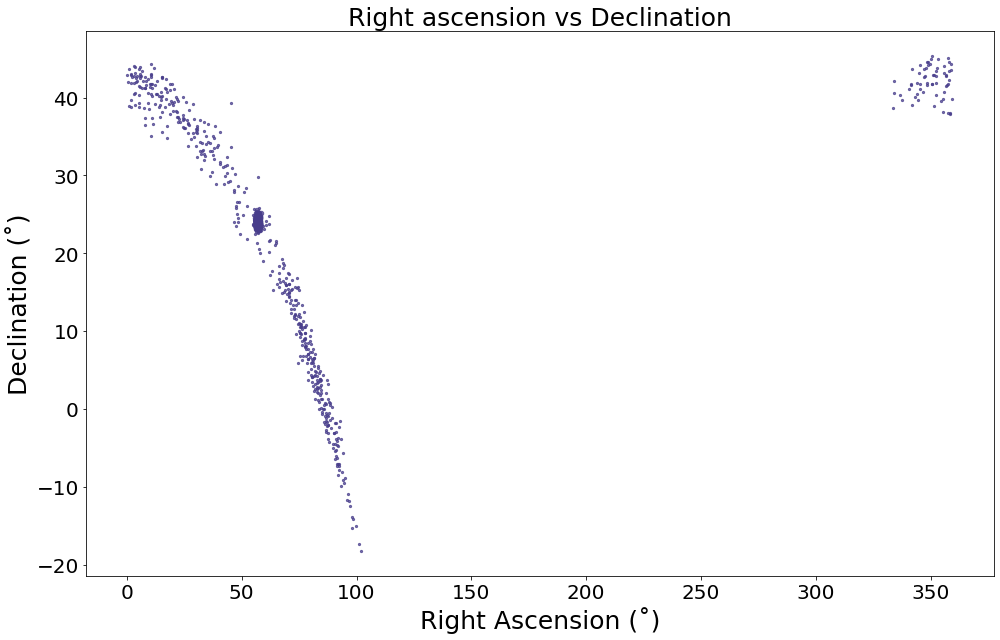

In [33]:
fig, axes = plt.subplots(1, 1, figsize=(14,9), sharex=True)

axes.scatter(Pleiades_stream_c[detectable_tail_stars].ra.degree,
             Pleiades_stream_c[detectable_tail_stars].dec.degree, 
             color = 'darkslateblue', marker='.', s=20, alpha=0.75)
axes.scatter(cluster_ras[detectable_cluster_stars],
             cluster_decs[detectable_cluster_stars], 
             color = 'darkslateblue', marker='o', s=20, alpha=0.75)

#plt.axis('square')

plt.title("Right ascension vs Declination", fontsize = 25)

axes.set_xlabel(r'Right Ascension (˚)', fontsize = 25)
axes.set_ylabel(r'Declination (˚)', fontsize = 25)
axes.tick_params(axis='both', which='major', labelsize=20)

#plt.xlim(326.5, 314)
#plt.ylim(13.5, 26)

fig.tight_layout()

#bestfit(Segue3_stream_c.ra.degree, Segue3_stream_c.dec.degree)

Text(0, 0.5, 'G')

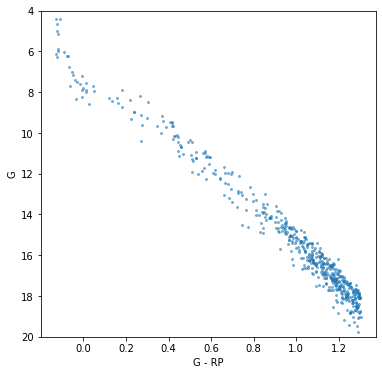

In [38]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(tail_mg - tail_mrp, tail_mg, alpha=0.5, s=4)
#ax.set_xlim(0, 1.1)
ax.set_ylim(20, 4)
ax.set_xlabel('G - RP')
ax.set_ylabel('G')

#ax.axhline(21.5)